# MIE1624 Assignment 1: Sentiment Analysis
### --- What can public opinion on Twitter tell us about the US airlines in 2015?


### Section 0: Preparation
Install and import all the necessary libraries required for the assignment.

In [497]:
''' 
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install textblob
!pip install wordcloud
'''

' \n!pip install numpy\n!pip install pandas\n!pip install sklearn\n!pip install textblob\n!pip install wordcloud\n'

In [498]:
import nltk, re, csv, html, wordcloud
# nltk.download()   # all files downloaded in the first run
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud

In [500]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [501]:
cd /Users/mac/Downloads/MIE1624/Assignment 1

/Users/mac/Downloads/MIE1624/Assignment 1


### Section 1: Data Cleaning
The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, the first step is to “clean” the data. The following process is designed to prepare the Twitter data for analysis by satisfying the requirements below:
- All html tags and attributes (i.e., /<[^>]+>/) are removed.
- Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
- All URLs are removed.
- All characters in the text are in lowercase.
- All stop wordsare removed. In this assignment, the 'stop_words.txt' was used
- If a tweet is empty after pre-processing, it should be preserved as such.

In [502]:
gentweets = pd.read_csv('generic_tweets.txt')
usatweets = pd.read_csv('US_airline_tweets.csv')
gentweets.head(5)

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [503]:
gentweets.shape

(200000, 6)

In [504]:
usatweets.head(5)

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [505]:
usatweets.shape

(11541, 6)

Since both datasets were collected directly from the web, they both contain 'noise' that need to be cleaned.

In [506]:
stopwords = open('stop_words.txt', 'r').read()
stopwords = stopwords.split('\n')
stopwords[0:3]

['a', 'able', 'about']

In [507]:
# this is the function that's I expect to clean the data as required
def DataCleaner(filename, shape):
    i = 0
    cleaned_twitter = []
    while i < shape: # 200000 or 11541
        twitter = filename.iloc[i]['text']
    
        # All html tags and attributes (i.e., /<[^>]+>/) are removed.
        twitter = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",'', twitter)

        # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
        twitter = html.unescape(twitter)

        # All URLs are removed.
        twitter = re.sub(r"http\S+", "", twitter)

        # All characters in the text are in lowercase.
        twitter = twitter.lower()

        # All stop words are removed. Again, 'stop_words.txt' was used
        nopunctokenizer = RegexpTokenizer('\w+')
        twitter = nopunctokenizer.tokenize(twitter)
        for word in twitter:
            if word in stopwords:
                twitter.remove(word)
        # meaningless strings (single letters) are removed.
        for word in twitter:
            if len(word) == 1:
                twitter.remove(word)
        twitter_sentence = ''
        for word in twitter:
            twitter_sentence = twitter_sentence + word + ' '
        twitter = twitter_sentence

        # this list will be used later to add new column to the DataFrame
        cleaned_twitter.append(twitter)

        # this was used for testing
        # print(twitter)


        i += 1
    return cleaned_twitter

In [508]:
gentweets['cleaned'] = DataCleaner(gentweets, 200000)
gentweets.head(5)

,class,id,date,query,user,text,cleaned
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr thir...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset he update facebook texting and cry resul...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived times ball managed save 50 the ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass it not behaving mad am here t ...


In [509]:
usatweets['cleaned'] = DataCleaner(usatweets, 11541)
usatweets.head(5)

,id,sentiment,negative_reason,user,retweet_count,text,cleaned
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,virginamerica you ve commercials the experienc...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,virginamerica aggressive blast obnoxious enter...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,virginamerica it big bad thing it
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,virginamerica seriously pay 30 flight seats di...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",virginamerica nearly time fly vx œear wormâ wo...


### Section 2: Exploratory Analysis
For further analysis, the US airlines mentioned in each tweet need to be identified. Functions are designed so that it's possible to gather the words after @ or #, since they are most likely to be followed by the names of the US airlines. The reasoning behind this "interpretaion" is that when people express their feelings towards certain airlines on the internet, they want to be "heard" by these airlines or other people who share the mutual feelings. The easiest way for them to do so is by using @ and #. Therefore, in this assignment, the primary focus is on the airlines that were hashtagged or "at-ed".  

In [510]:
# this is the function that I expect to return the @s and #s
def AtHashtags(filename, shape): 
    i = 0
    athashtag = []
    while i < shape: # 200000 or 11541
        things = ''
        twitter = filename.iloc[i]['text']
        wordlist = word_tokenize(twitter)
        if '@' in wordlist and wordlist.index('@') < (len(wordlist) - 1):
            num = wordlist.index('@') + 1
            things += wordlist[num] + ' '
        if '#' in wordlist and wordlist.index('#') < (len(wordlist) - 1):
            num = wordlist.index('#') + 1
            things += wordlist[num] + ' '
        athashtag.append(things)
        i += 1
    return athashtag

In [511]:
usatweets['@ and #'] = AtHashtags(usatweets, 11541)
usatweets.head(5)

,id,sentiment,negative_reason,user,retweet_count,text,cleaned,@ and #
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,virginamerica you ve commercials the experienc...,VirginAmerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,virginamerica aggressive blast obnoxious enter...,VirginAmerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,virginamerica it big bad thing it,VirginAmerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,virginamerica seriously pay 30 flight seats di...,VirginAmerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",virginamerica nearly time fly vx œear wormâ wo...,VirginAmerica


In [512]:
# Below, a new data frame was created 
# this is the function I expect to reveal the number of times that airlines were mentioned in the collected tweets
def CollectAirline(filename, shape):
    i = 0
    airlines = []
    while i < shape: # 200000 or 11541
        twitter = filename.iloc[i]['@ and #']
        twitter = word_tokenize(twitter)
        for item in twitter:
            airlines.append(item.lower())
        i += 1
    return airlines

In [513]:
airline_freq = Counter(CollectAirline(usatweets, 11541))
airlinefreq = pd.DataFrame.from_dict(airline_freq, orient = 'index').reset_index()
airlinefreq = airlinefreq.rename(columns={'index':'airline', 0:'count'})
airlinefreq = airlinefreq.sort_values(by='count', ascending=False)
airlinefreq.head(10)

,airline,count
64,united,3143
826,usairways,2545
403,americanair,2292
107,southwestair,1754
637,jetblue,1526
0,virginamerica,334
3,fail,54
444,destinationdragons,31
83,unitedairlines,30
15,customerservice,27


Text(0.5, 0, 'Airlines')

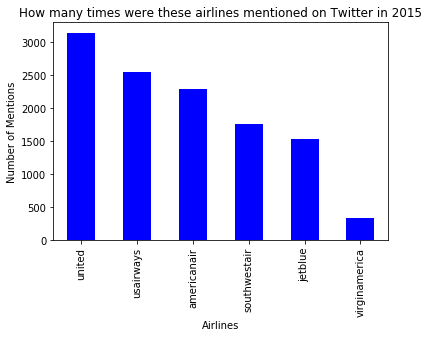

In [514]:
# since united and united airlines are expected to be the same thing, thet are added together
airlinefreq.at['0', 'count'] = 3143 + 30 
first_plot = airlinefreq.iloc[0:6].plot('airline', by='count', legend=False, \
                                        kind='bar', color='blue', \
                                        title='How many times were these airlines mentioned on Twitter in 2015')
first_plot.set_ylabel('Number of Mentions')
first_plot.set_xlabel('Airlines')

The bar chart above was generated to visualize several "most popular" airlines on Twitter in 2015. It's observed that in 2015, United Airline had the largest amount of mentions, followed by USAirways and AmericanAir, both of them had more than 2000 times of mentions. As to the less popular airlines, SouthwestAir and JetBlue both had more than 1500 times of mentions, whereas VirginAmerica was only mentioned about 300 times, being the least popular airline amoung the six in USA in 2015.   

In [515]:
# this is the function I expect to assist in generating word cloud
def PrepWordCloud(filename, shape):
    i = 0
    word = ''
    while i < shape: # 200000 or 11541
        words = filename.iloc[i]['cleaned']
        words = word_tokenize(words)
        for item in words:
            word += str(item) + ' '

        i += 1
    return word

In [516]:
words = PrepWordCloud(gentweets, 200000)

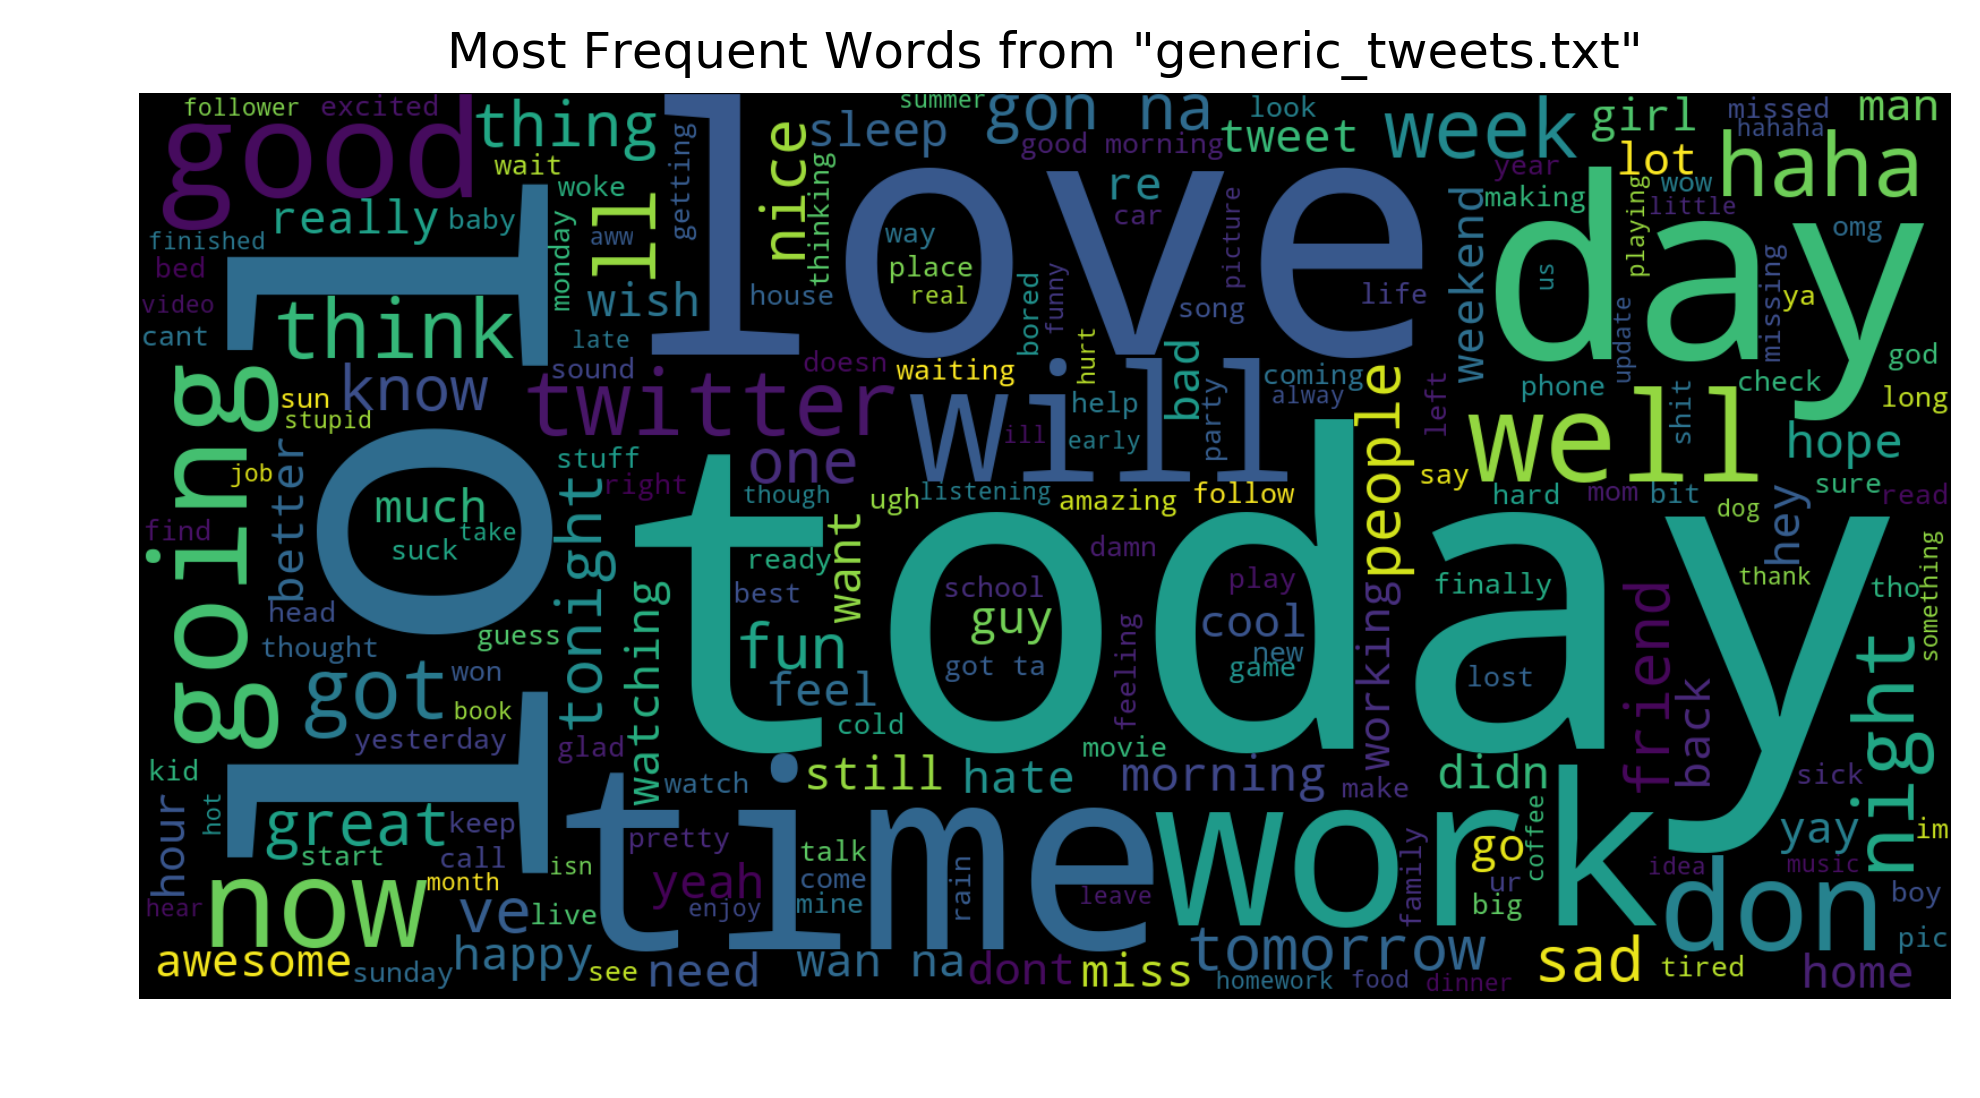

In [517]:
wordcloud = WordCloud(width=1600,height=800).generate(words)
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequent Words from "generic_tweets.txt"')
plt.axis("off")
plt.show() 

In [518]:
word2 = PrepWordCloud(usatweets, 11541)

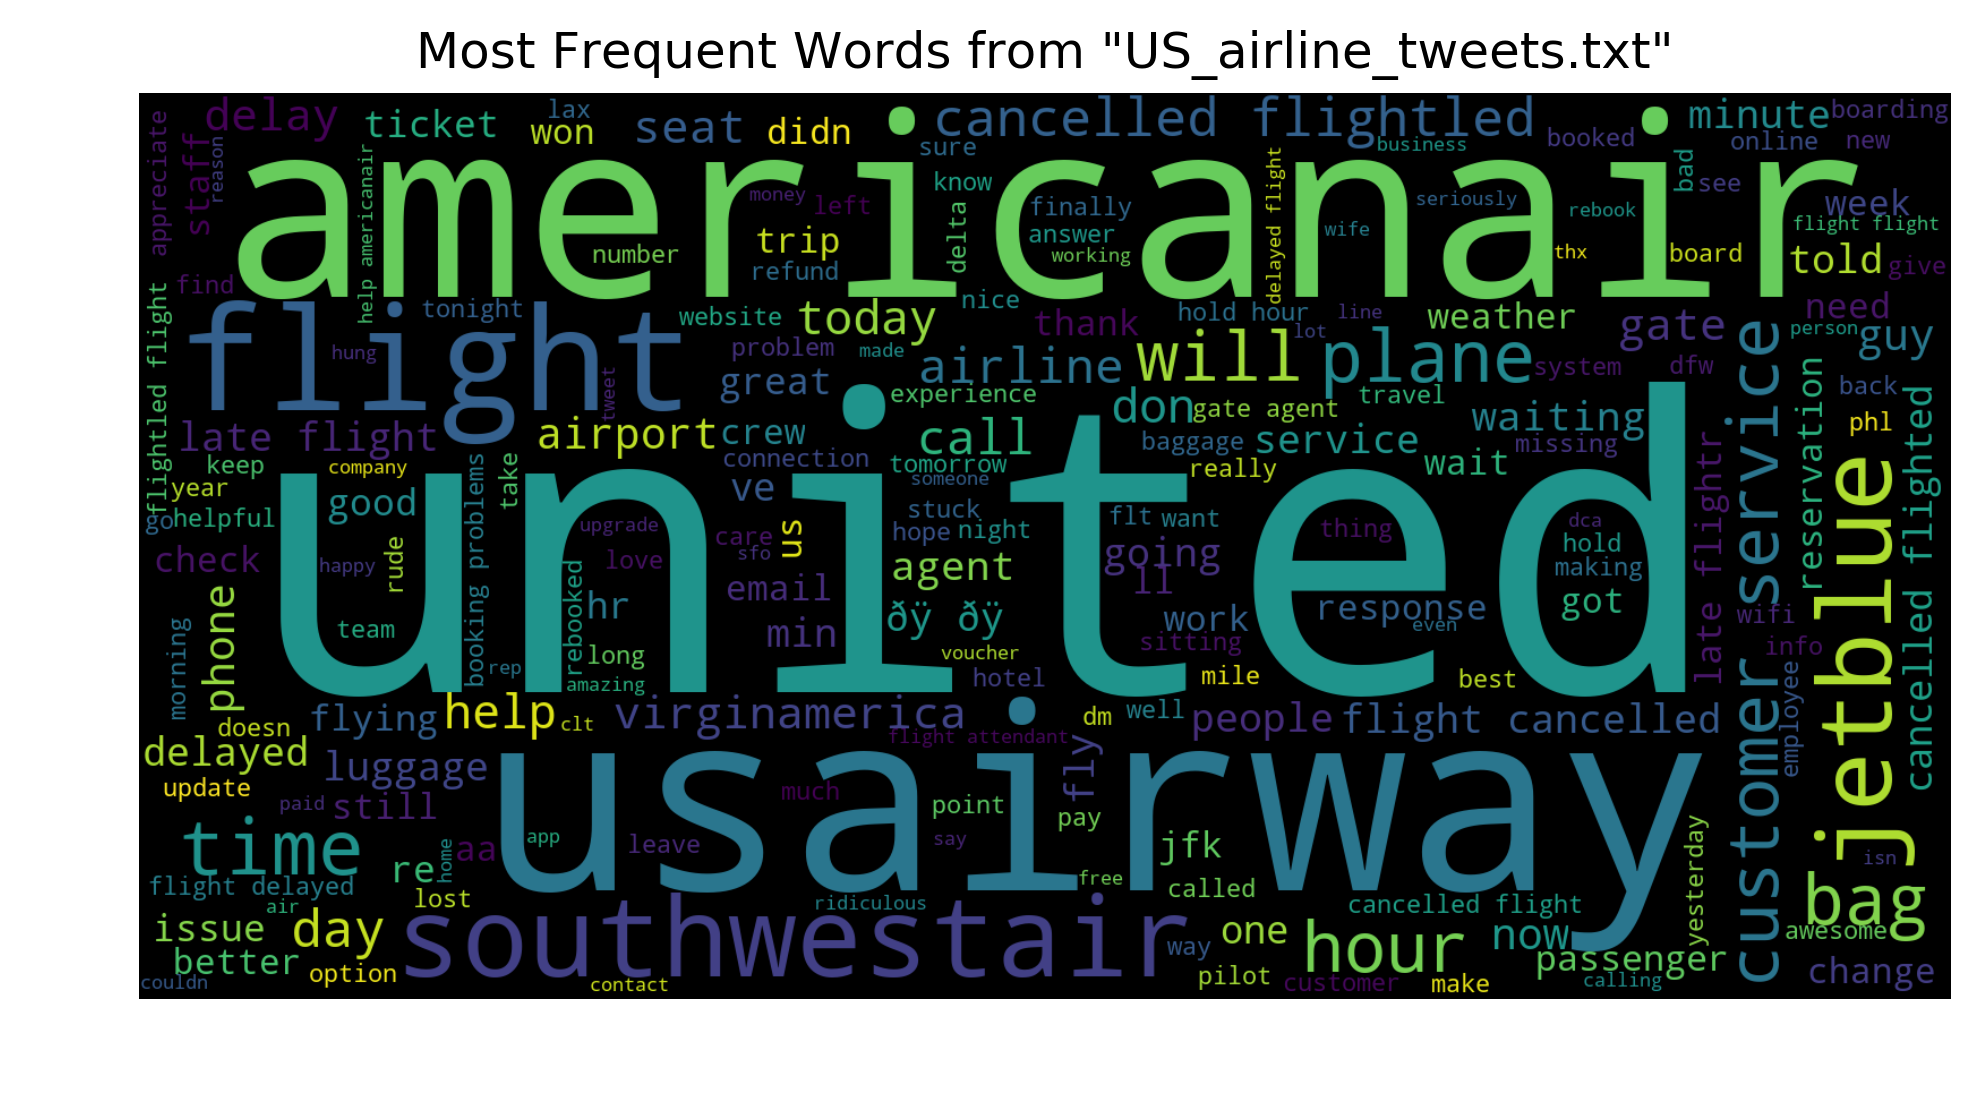

In [519]:
wordcloud = WordCloud(width=1600,height=800).generate(word2)
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequent Words from "US_airline_tweets.txt"')
plt.axis("off")
plt.show() 

The first word cloud reveals the most frequently used words in 'generic_tweets.txt'. As observed, the word 'today' is the most frequently used words, meaning that these tweets were probably wrote right before they users took off or right after they landed. At the meantime, words like 'lol', 'good', 'love' are also frequently uesd, meaning in the tweets collected, more people expressed positive feeling about the airlines. 

The second word cloud reveals the most frequently used words in 'US_airline_tweets.csv'. Similar to the previous bar chart presented, the top three most 'popular' airlines in 2015 are United Airlines, USAirway and AmericanAir. This also proves that the 'prediction' made at the begining of this section is correct (aka airlines often apper after @ and #).

### Section 3: Model Preparation
In this section, the generic tweets were splited into training data (70%) and test data (30%). As for the logistic regression model, the outcome variable is the sentiment value (in this case, the 'score'). For the independent feature, the corpus score of each tweet was computed using 'corpus.txt', words that are not listed in 'corpus.txt' were assigned 0.

In [520]:
# make a dictionary out of 'corpus.txt' 
corptext = open('corpus.txt', 'r').read()
corptext = corptext.split('\n')
corp_txt = []
for item in corptext:
    for itm in item.split('\t'):
        corp_txt.append(itm)

corp_tt = {corp_txt[i]: corp_txt[i+1] for i in range(0, len(corp_txt), 2)}

In [521]:
# this is the function I expect to compute the corpus score as factor using 'corpus.txt'
def SentCalc(filename, file_name, shape):
    
    i = 0
    sentcalc = []
    while i < shape: # 200000 or 11541
        twitter = filename.iloc[i]['cleaned']
        twitter = word_tokenize(twitter)
        num = 0
        for item in twitter:
            if item in file_name:
                number = int(file_name[item])
            else:
                number = 0
            num += number
            
        sentcalc.append(num)
        
        
        i += 1
    return sentcalc

In [522]:
gentweets['factor'] = SentCalc(gentweets, corp_tt, 200000)

In [523]:
# positive emotion class 4 == score 1; negative emotion class 0 == score 0
gentweets['score'] = gentweets['class'].apply(lambda x: 1 if x == 4 else 0)

In [524]:
factor = gentweets[['factor']]
result = gentweets['score']

In [525]:
factor_train, factor_test, result_train, result_test = train_test_split(factor, result, test_size=0.3)

### Section 4: Model Implementation
In this section, a logistic regression model was trained using the training data obtained from the previous section, then the model as applied to the test data as well as the US airline data.

In [526]:
model = LogisticRegression()
model.fit(factor_train, result_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [527]:
predictions = model.predict(factor_test)
score = accuracy_score(result_test,predictions)
print (" The accuracy of the model is {}% ".format(round(score*100,2)))

 The accuracy of the model is 62.2% 


In [528]:
print (confusion_matrix(result_test,predictions))
print (classification_report(result_test,predictions))

[[21858  8096]
 [14587 15459]]
              precision    recall  f1-score   support

           0       0.60      0.73      0.66     29954
           1       0.66      0.51      0.58     30046

   micro avg       0.62      0.62      0.62     60000
   macro avg       0.63      0.62      0.62     60000
weighted avg       0.63      0.62      0.62     60000



In [529]:
usatweets['factor'] = SentCalc(usatweets, corp_tt, 11541)
usatweets['score'] = usatweets['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [530]:
feature = usatweets[['factor']]
outcome = usatweets[['score']]
predictions_1 = model.predict(feature)
score_1 = accuracy_score(outcome, predictions_1)
print (" The accuracy of the model is {}% ".format(round(score_1*100,2)))
print (confusion_matrix(outcome, predictions_1))
print (classification_report(outcome, predictions_1))

 The accuracy of the model is 67.74% 
[[6160 3018]
 [ 705 1658]]
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      9178
           1       0.35      0.70      0.47      2363

   micro avg       0.68      0.68      0.68     11541
   macro avg       0.63      0.69      0.62     11541
weighted avg       0.79      0.68      0.71     11541



As showed above, the accuracy of the model on the test data is 62.19% and even higher accuracy on the US airline data at 67.74%. This may be caused by the fact that a lot of tweets don't contain words from 'corpus.txt' and therefore assigned 0 as input, however, this doesn't mean these tweets are neutral, it just shows that the model may need better input features if a higher accuracy is desired.

Next step, the negative US airline data was splited into 70% training data and 30% test data in order to build a multiclass logistic regression model. The negative reasons provided were divided into different groups (reasoning provided below), and each group was assigned an numeric value as the outcome of the model. The same input feature, the corpus score was used to prepare this model, the additional feature being the length of the tweet. Discussion on the results are included in Section 5.

In [531]:
usatweets_neg = usatweets[usatweets['sentiment'] == 'negative']
usatweets_neg['negative_reason'] = usatweets_neg['negative_reason'].astype('category')
usatweets_neg['negative_reason'].cat.categories

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['Bad Flight', 'Can't Tell', 'Cancelled Flight',
       'Customer Service Issue', 'Damaged Luggage',
       'Flight Attendant Complaints', 'Flight Booking Problems', 'Late Flight',
       'Lost Luggage', 'longlines'],
      dtype='object')

In [532]:
def ReasonScore(filename, shape):
    i = 0
    reasonscore = []
    while i < shape: # 9178
        reason = filename.iloc[i]['negative_reason']
        # these three mostly due to experience on the plane
        if reason == 'Bad Flight' or reason == 'Flight Attendant Complaints' or reason == "Customer Service Issue":
            reasonscore.append(1)
        # these two both related to luggage
        elif reason == "Damaged Luggage" or reason == 'Lost Luggage':
            reasonscore.append(2)
        # these three all related to issues happening before boarding the plane
        elif reason == 'Cancelled Flight' or reason == 'Late Flight' or reason == 'longlines':
            reasonscore.append(3)
        elif reason == 'Flight Booking Problems':
            reasonscore.append(4)
        elif reason == "Can't Tell":
            reasonscore.append(0)
        
        i += 1
    return reasonscore

In [533]:
usatweets_neg['Neg Score'] = ReasonScore(usatweets_neg, 9178)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [534]:
# this was used as testing feature, could be included for further analysis
usatweets_neg['length'] = usatweets_neg['text'].apply(len)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [535]:
feature_0 = usatweets_neg[['factor']]
outcome_0 = usatweets_neg['Neg Score']
feature_0_train, feature_0_test, outcome_0_train, outcome_0_test = train_test_split(feature_0, outcome_0, test_size=0.3)

In [536]:
model_0 = LogisticRegression()
model_0.fit(feature_0_train, outcome_0_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [537]:
predictions_0 = model_0.predict(feature_0_train)
score_0 = accuracy_score(outcome_0_train,predictions_0)
print (" The training accuracy of the model is {}% ".format(round(score_0*100,2)))
print (classification_report(outcome_0_train, predictions_0))
print (confusion_matrix(outcome_0_train,predictions_0))

 The training accuracy of the model is 43.15% 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       816
           1       0.44      0.96      0.60      2782
           2       0.00      0.00      0.00       574
           3       0.34      0.05      0.09      1881
           4       0.00      0.00      0.00       371

   micro avg       0.43      0.43      0.43      6424
   macro avg       0.15      0.20      0.14      6424
weighted avg       0.29      0.43      0.29      6424

[[   0  780    0   36    0]
 [   0 2677    0  105    0]
 [   0  541    0   33    0]
 [   0 1786    0   95    0]
 [   0  360    0   11    0]]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [538]:
predictions_0 = model_0.predict(feature_0_test)
score_0 = accuracy_score(outcome_0_test,predictions_0)
print (" The testing accuracy of the model is {}% ".format(round(score_0*100,2)))
print (classification_report(outcome_0_test, predictions_0))
print (confusion_matrix(outcome_0_test,predictions_0))

 The testing accuracy of the model is 42.27% 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.43      0.95      0.59      1189
           2       0.00      0.00      0.00       224
           3       0.25      0.04      0.06       809
           4       0.00      0.00      0.00       158

   micro avg       0.42      0.42      0.42      2754
   macro avg       0.14      0.20      0.13      2754
weighted avg       0.26      0.42      0.27      2754

[[   0  353    0   21    0]
 [   0 1135    0   54    0]
 [   0  213    0   11    0]
 [   0  780    0   29    0]
 [   0  156    0    2    0]]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Section 5: Results
This section provides required answers (or so I thought).

**Q1 Based on the outputs of your first model, describe the results of the analysis and discuss your interpretation of the results. Explain how each airline is viewed in the public eye based on the sentiment value.**

Based on the first model, 11541 tweets were analyzed and 6865 of them were marked as 0 and 4676 of them were marked as 1, meaning more tweets expressed negative feeling towards the US airlines in 2015. Compared to the provided result, the current model is quite "optimistic", since fewer tweets were considered negative. The results are reasonable, considering most people would rather complain on Twitter than sharing good experience on it. Often times, the good experiences are shared with close friends either in person or on other 'personal' social networks (Facebook, Instagram, etc.) 

To analyze the public opinions on each individual airlines, the average of their 'positive/negative' was calculated, since positive was referred as 1 and negative referred as zero, a greater average meaning relatively more positive public opninion. 

In [539]:
key = ['virginamerica', 'usairways', 'unitedairlines', 'jetblue', 'southwestair', 'americanair']
key = {key: None for key in key}

In [540]:
# calculate the average
def Feelings(filename, air, shape):
    
    i = 0
    count_tot = 0
    count_pos = 0
    average = 0
    while i < shape:
        airline = filename.iloc[i]['@ and #']
        airline = airline.lower()
        airline = word_tokenize(airline)
        for word in airline:
            if word == air:
                count_tot += 1
                count_pos += filename.iloc[i]['score']
        
        i += 1
    average = count_pos / count_tot  
    return  count_pos, count_tot, average

In [541]:
_, _, key['virginamerica'] = Feelings(usatweets, 'virginamerica', 11541)
_, _, key['usairways'] = Feelings(usatweets, 'usairways', 11541)
_, _, key['jetblue'] = Feelings(usatweets, 'jetblue', 11541)
_, _, key['southwestair'] = Feelings(usatweets, 'southwestair', 11541)
_, _, key['americanair'] = Feelings(usatweets, 'americanair', 11541)

In [542]:
sum_one, _, _ = Feelings(usatweets, 'unitedairlines', 11541)
sum_two, _, _ = Feelings(usatweets, 'united', 11541)
_, sum_tre, _ = Feelings(usatweets, 'unitedairlines', 11541)
_, sum_fou, _ = Feelings(usatweets, 'united', 11541)
key['unitedairlines'] = (sum_one + sum_two) / (sum_tre + sum_fou)

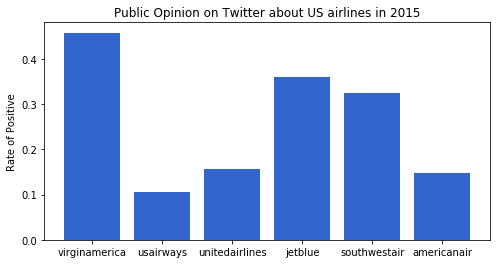

In [543]:
plt.figure(figsize=(8,4))
plt.bar(range(len(key)), list(key.values()), align='center', color=(0.2, 0.4, 0.8))
plt.xticks(range(len(key)), list(key.keys()))
plt.title("Public Opinion on Twitter about US airlines in 2015")
plt.ylabel('Rate of Positive')
plt.show()

As the bar chart above reveals, VirginAmerica has the highest ratings, followed by JetBlue and SouthwestAir, whereas USAirways, UnitedAirlines and AmericanAir all have relatively low ratings. It worth pointing out that, even though VirginAmerica has the highest rating based on the model, the amount of data collected was relatively small compared to the data on other airlines, therefore, the highest rating doesn't necessarily link to the best experience in reality.

**Q2 Based on the second model, provide a few reasons why your model failed to predict the correct negative reasons. Back up your reasoning with examples from the test sets.**

The second model has 43.15% accuracy with the training data and 42.74% accuracy witht the test data, compare to the first model, it's a complete failure. Reasons include:
   - 1) only one feature was used in the model, the 1-D array input may have worked well with logistic regression, but for multiclass logistic regression, more inputs may be more desirable; 
   - 2) the input is computed using the corpus.txt which rate the words based on their 'emotions', it doesn't have a strong connection to the reasons behind thoes emotions. Compare to the first model, where the output is just the positive or negative emotions, the corpus scores on the words used have a more 'direct' link to the result. For instance, according the second model built, a delayed flight tweet doesn't necessarily contain negative corpus score words. 
   - 3) the grouping criteria for the negative reasons could be perfected.

**Q3 For both models, suggest one way you can improve the accuracy of your models?**

Suggestions:
- Equally distributed data collections on each individual airlines.
- Prepare database that rates the words based on different scale other than emotions, for instance the word 'late' doesn't appear in the corpus.txt, but can be a useful keywords that potentially suggest 'longlines' or even 'Late Flight'

### Reference

- Lecture slides, ipynb; 
- Tutorial slides, ipynb;
- Geeks' Q&A on StackOverflow...

### Bonus

For Section 3, attempt to visualize the logistic regression models using Heatmap on the confusion matrix of the US tweets. (A better model than the second one.)

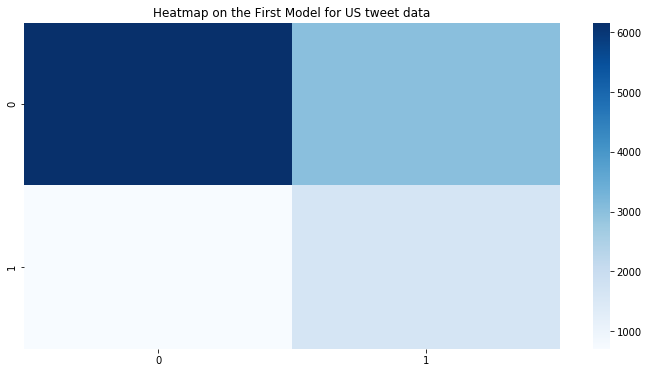

In [544]:
array = [[6160, 3018],
            [705, 1658]]

ustweet_hm = pd.DataFrame(array, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (12,6))
sn.heatmap(ustweet_hm, cmap='Blues')
plt.title("Heatmap on the First Model for US tweet data")
plt.show()

For Section 4, attempt to visualize the logistic regression models using Heatmap, which further proves the failure of the second model.

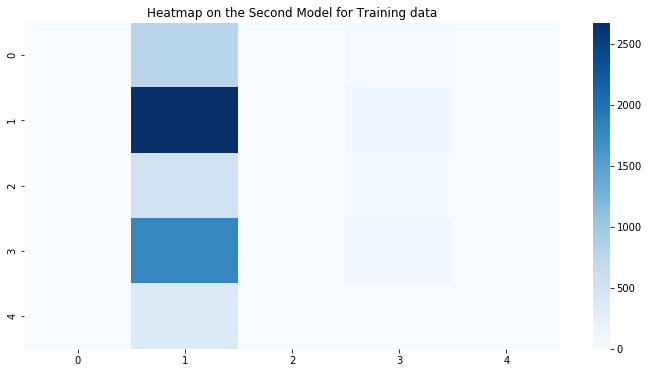

In [545]:
array = [[0, 786, 0, 41, 0],
         [0, 2672, 0, 112, 0],
         [0, 537, 0, 30, 0],
         [0, 1789, 0, 87, 0],
         [0, 361, 0, 9, 0]]

train_hm = pd.DataFrame(array, index = [i for i in "01234"],
                  columns = [i for i in "01234"])
plt.figure(figsize = (12,6))
sn.heatmap(train_hm, cmap='Blues')
plt.title("Heatmap on the Second Model for Training data")
plt.show()

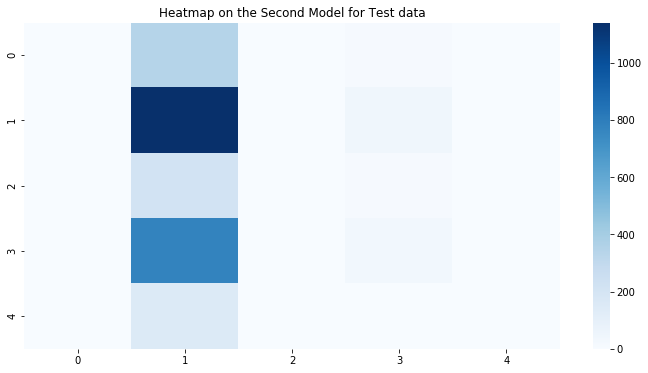

In [546]:
array = [[   0,  347,    0,   16,    0],
         [   0, 1140,    0,   47,    0],
         [   0,  217,    0,   14,    0],
         [   0,  777,    0,   37,    0],
         [   0,  155,    0,    4,    0]]

test_hm = pd.DataFrame(array, index = [i for i in "01234"],
                  columns = [i for i in "01234"])
plt.figure(figsize = (12,6))
sn.heatmap(test_hm, cmap='Blues')
plt.title("Heatmap on the Second Model for Test data")
plt.show()